## 🧩 Adaptive Masked Robust Regression (AMRR) for Image Reconstruction

This notebook implements an algorithm to reconstruct a partially corrupted image frame using
a set of clean reference images. It identifies a reliable subset of pixels and performs robust
regression to reconstruct the corrupted/missing values.


In [2]:
import numpy as np
import os
from PIL import Image

### Image Loading and Vectorization

- `get_data(folder_path)`: Loads RGB images from a folder and converts them to flattened vectors.
- Selects one special image (frame 196) as the target image `y` to be reconstructed.
- The rest are stacked column-wise to form matrix `A`, representing reference image data.

In [3]:
def get_data(folder_path):

    image_list = []
    image_array_list = []
    img_paths = []

    # Load images from the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):  # Check file extensions
            
            image_path = os.path.join(folder_path, filename)
            img = Image.open(image_path)  # Load image
            
            img_array = np.array(img)
            if img_array.shape != (720, 1280, 3):
                # print(img_array.shape)
                if img_array.shape[2] == 4:  # If the image has an alpha channel
                    img_array = img_array[:, :, :3]  # Discard the alpha channel
            img_array = img_array.flatten() # numpy array
            if "196" in filename:
                # print(filename)
                y_img = img
                y_array = img_array
                y_path = image_path
                continue
            image_list.append(img)  # Append image to list
            image_array_list.append(img_array) # Append np.array to list
            img_paths.append(image_path)
    
    print(f"Loaded {len(image_list)} images.")
    image_array_list
    matrix = np.column_stack(image_array_list)  # Create a matrix where each column is an image
    A_rescaled = matrix.astype(np.float64)
    y_matrix = np.column_stack(y_array)
    y_rescaled = y_matrix.astype(np.float64).reshape(-1,1)
    print(f"y shape: {y_rescaled.shape}")
    print(f"Rescaled images to shape: {A_rescaled.shape}")
    print(f"Range of A: [{min(0, A_rescaled.min())}, {max(255,A_rescaled.max())}]")
    return A_rescaled, y_rescaled




### Helper: Set Complement
- `complement(S, m)`: Computes the complement of a subset `S` with respect to the full index set {0, ..., m-1}.


In [4]:
def complement(S, m):
    """
    Compute the complement of set S with respect to the range {0, 1, ..., m-1}.

    Args:
        S (np.ndarray or list): Subset of indices.
        m (int): Total number of elements in the full set.

    Returns:
        np.ndarray: Complement of S.
    """
    full_set = np.arange(m)
    complement_set = np.setdiff1d(full_set, S, assume_unique=True)
    return complement_set

### Adaptive Masked Robust Regression (AMRR)

- `amrr`: Iteratively finds a subset of pixels `S` with smallest residuals and solves a least squares
  problem to reconstruct the image.
- At each iteration:
  1. Solve `x = argmin ||A(S,:)x - y(S)||`
  2. Compute residuals `r = A(S,:)x - y(S)`
  3. Select next `S` as indices with lowest residuals
- Stops when residual norm no longer improves.

In [31]:
# m = A.shape[0]
# l = 10*1280*3 #m - np.abs(S) 
def amrr(A, y, sizeS, tol=1e-6): # -> 

    """
    Arguments:
        A: input shape: 2764800 x 10
        Y: output, frame 196 shape: 1 x 2764800
        sizeS: size of set S between 1 and m
        tol: tolerance


    convergence: f(x^i+1, S^i+1) >= f(x^i, S^i) - tol
    Returns: 
        x: vector that minimizes ||y(S) - A(S, :)x||
        S: set of m-l entries over which the minimizer is taken
        Scomp: compliment of S wrt {1,...,m}
        numit: number of iterations
    """
    
    S = [i for i in range(sizeS)]
    maxit = 10
    x = np.zeros((A.shape[1], 1))
    r = np.zeros_like(y)
    # print(f"A SHAPE: {A[S, :].shape}")
    # print(f"Y shape: {y[S].shape}")
    # print(f"x shape: {x.shape}")

    norm = np.linalg.norm(y[S] - A[S, :]@x)
    # norm = 0
    numit = maxit
    # print("here")
    for k in range(maxit):
        try:
            
            A_S = A[S, :]
            y_S = y[S]
            # print(f"A_S SHAPE: {A_S.shape}")
            # print(f"Y_s shape: {y_S.shape}")
            x_next = np.linalg.lstsq(A_S, y_S, rcond=None)[0] #shape (10,1)
            # print(f"x_next shape: {x_next.shape}")
            r_next = A_S@x_next - y_S # shape 2764800 x 1
            # print(f"r next shape: {r_next.shape}")
            S_next = list(np.squeeze(np.argsort(np.abs(r_next))[:sizeS], axis=1))
            # try:
            #     print(f"s_NEXT shape: {S_next.shape}")
            # except:
            #     print(f" S_next len: {len(S_next)}" )
            #check convergence
            norm_next = np.linalg.norm(y[S_next] - A[S_next, :]@x_next)

            x = x_next
            r = r_next
            S = S_next
            norm = norm_next

            if norm_next >= norm-tol:
                print(f"converged at iteration: {k+1}")
                numit=k+1
                break
            if k%10 == 0:
                print(k)
        except Exception as e:
            print(f"Error in iteration: {k}")
            raise(e)
    Scomp = np.setdiff1d(np.arange(A.shape[0]), S, assume_unique=True)
    return x, S, Scomp, numit
        

       


    

### Image Reconstruction Visualization
- `generate_images`: Reconstructs the target image `y` using prediction `Ax`, keeping values in `S` unchanged
  and estimating others from regression.
- Displays original vs reconstructed frame side-by-side.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def generate_images(A, y, x, S, Scomp, image_shape = (720, 1280, 3)):
    """
    Generate and display two images based on the problem description.

    Args:
        A (np.ndarray): Input matrix (e.g., 2764800 x 10).
        y (np.ndarray): Original RGB frame (vectorized, shape: 2764800,).
        x (np.ndarray): Solution vector from least-squares (shape: 10,).
        S (np.ndarray): Indices of the set S.
        Scomp (np.ndarray): complement indices of the set S.
        image_shape (tuple): Shape of the original image (e.g., (720, 1280, 3)).

    Returns:
        y_image (np.ndarray): First image (reshaped y).
        y_prime_image (np.ndarray): Second image (reshaped y').
    """
    # Initialize y' as a copy of y
    y_prime = np.copy(y)

    # Compute the complement of S (S^c)
    m = len(y)
    # S_complement = np.setdiff1d(np.arange(m), S, assume_unique=True)

    # Replace values in y' at indices S_complement with predictions from Ax
    y_prime[Scomp] = (A @ x)[Scomp]

    # Reshape y and y' to the original image format
    y_image = y.reshape(image_shape)
    y_prime_image = y_prime.reshape(image_shape)

    # Display the images
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(y_image / 255)  # Normalize for display
    plt.title("Original Image (y)")
    plt.axis("off")

    # Modified image
    plt.subplot(1, 2, 2)
    plt.imshow(y_prime_image / 255)  # Normalize for display
    plt.title("Modified Image (y')")
    plt.axis("off")

    plt.show()

    return y_image, y_prime_image

# Example usage:
# Assuming A, y, x, and S are already computed
image_shape = (720, 1280, 3)  # Replace with actual shape



### Driver: Run the AMRR Pipeline

- Loads images
- Computes regression model and reliable pixel set `S`
- Generates and displays reconstructed image from predicted values

In [32]:
def amrr_driver(data_folder):

    A,y = get_data(data_folder)

    m = A.shape[0]
    l = int(10*m/720) #m - np.abs(S) 
    sizeS = int(m-l)
    tol = 1e-7

    x, S, Scomp, numit = amrr(A=A, y=y, sizeS=sizeS, tol=tol)

    y_image, y_prime_image = generate_images(A, y, x, S, Scomp)


    

### Execute the Pipeline
- Calls `amrr_driver` with folder `railroad_dataset`
- Runs full AMRR pipeline and outputs reconstruction results

Loaded 10 images.
y shape: (2764800, 1)
Rescaled images to shape: (2764800, 10)
Range of A: [0, 255]
converged at iteration: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.01513301564841778..1.0333683679482657].


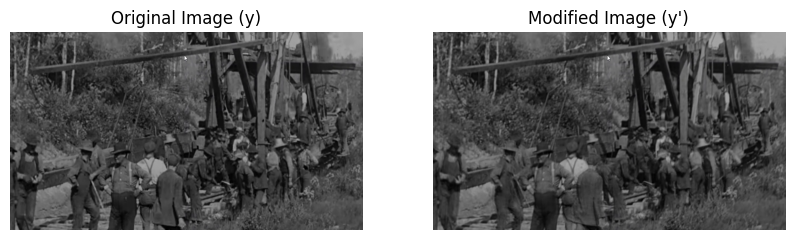

In [ ]:
data_path = "railroad_dataset"
# A, y = get_data(data_path)
amrr_driver(data_path)

Adding a red circle around the black spot in the **Original Image (y)** to help identify the difference more easily.


![Annotated Image](image_with_adjusted_circle.png)